# 5. Training 
 --------------------------------------------------------------------

Train a model using a snapshot of the data.

![Model deployment with streaming Real-time operational Pipeline](../../assets/images/model-deployment-with-streaming.png)

In [1]:
%run config.py

## Step 1: Create and Configure a New Project <a id="gs-step-project-create-n-config"></a>

### Create a New Project <a id="gs-create-project"></a>

In [3]:
from os import path, getenv
from mlrun import new_project, load_project

project_name = '-'.join(filter(None, [PROJECT_NAME, getenv('V3IO_USERNAME', None)]))
project_path = path.abspath('conf')
if path.isfile(path.join(project_path, 'project.yaml')):
    project = load_project(name=project_name, context=project_path, init_git=False)
else:
    project = new_project(project_name, project_path, init_git=True)

print(f'Project path: {project_path}\nProject name: {project_name}')

Project path: /User/rapid-streaming-ml/conf
Project name: model-deployment-with-streaming-michaelk


### Configure MLRun <a id="gs-mlrun-config"></a>

In [4]:
from mlrun import run_local, NewTask, mlconf, import_function, mount_v3io

# Target location for storing pipeline artifacts
artifact_path = path.abspath('artifacts')
# MLRun DB path or API service URL
mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'

print(f'Artifacts path: {artifact_path}\nMLRun DB path: {mlconf.dbpath}')

Artifacts path: /User/rapid-streaming-ml/artifacts
MLRun DB path: http://mlrun-api:8080


#### Import Nuclio <a id="gs-nuclio-import"></a>


In [5]:
import nuclio

In [6]:
# nuclio: start-code

In [7]:
%nuclio config spec.build.baseImage = "mlrun/ml-models"
%nuclio config kind = "job"
%nuclio cmd -c pip install v3io-frames==0.6.18

%nuclio: setting spec.build.baseImage to 'mlrun/ml-models'
%nuclio: setting kind to 'job'


## Step 2: Take a Snapshot Data Set of the KV feature table <a id="gs-step-ingest-data"></a>


### Initialization <a id="gs-step-ingest-data-init"></a>


In [8]:
# nuclio: ignore
# Set the source-data URL
container = CONTAINER
table_path = '/' + FEATURE_TABLE_PATH
columns = ['label', 'socioeconomic_idx', 
           'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 
           'bet_sum', 'bet_mean', 'bet_count' ,'bet_var',
           'win_sum', 'win_mean', 'win_count' ,'win_var']
format = 'csv'

### Define a Data-Snapshot Function <a id="gs-step-ingest-data-define-function"></a>


In [9]:
from os import path
import pandas as pd
import v3io_frames as v3f


# Ingest a data set into the platform
def snapshot_data(context, container, table_path, columns, format='csv'):
    
    client = v3f.Client("framesd:8081", container=container)
    client.execute(backend="kv", table=table_path, command="infer")
    df = client.read('kv', table_path, columns=columns)
    
    target_path = path.join(context.artifact_path, 'data')
    # Optionally print data to your logger
    context.logger.info('Saving snapshot data set to {} ...'.format(target_path))
    
    # Store the data set in your artifacts database
    context.log_dataset('snapshot_dataset', df=df, format=format,
                        index=False, artifact_path=target_path)

In [10]:
# nuclio: end-code

<a id='gs-run-ingest-func-local'></a>
#### Run the Function Locally in Jupyter Notebook

In [11]:
# Run the data-ingestion function locally in Jupyter Notebook
snapshot_data_run = run_local(name='snapshot_data',
                         handler=snapshot_data,
                         params={'container': container, 'table_path': table_path, 
                                 'columns':columns, 'format': format},
                         project=project_name, artifact_path=artifact_path)

> 2020-08-06 13:13:21,650 [info] starting run snapshot_data uid=d094e5871dfa4c29aa777f9520259942  -> http://mlrun-api:8080
> 2020-08-06 13:13:21,974 [info] Saving snapshot data set to /User/rapid-streaming-ml/artifacts/data ...


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-deployment-with-streaming-michaelk,...20259942,0,Aug 06 13:13:21,completed,snapshot_data,v3io_user=michaelkkind=handlerowner=michaelkhost=jupyter-mk-7c7fc6cc67-fkkvj,,"container=userstable_path=/michaelk/examples/model-deployment-with-streaming/data/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run d094e5871dfa4c29aa777f9520259942 --project model-deployment-with-streaming-michaelk , !mlrun logs d094e5871dfa4c29aa777f9520259942 --project model-deployment-with-streaming-michaelk
> 2020-08-06 13:13:22,149 [info] run executed, status=completed


#### Run the Function on a Cluster <a id="gs-run-ingest-func-cluster"></a>


In [11]:
from mlrun import code_to_function

# Convert the local snapshot_data function into a gen_func project function
gen_func = code_to_function(name='snapshot-data')
project.set_function(gen_func)
snapshot_data_func = project.func('snapshot-data').apply(mount_v3io())

In [12]:
#Build image
snapshot_data_func.deploy()

[mlrun] 2020-08-05 07:24:33,391 starting remote build, image: .mlrun/func-model-deployment-with-streaming-iguazio-snapshot-data-latest
INFO[0000] Resolved base name mlrun/ml-models:0.4.10 to mlrun/ml-models:0.4.10 
INFO[0000] Resolved base name mlrun/ml-models:0.4.10 to mlrun/ml-models:0.4.10 
INFO[0000] Retrieving image manifest mlrun/ml-models:0.4.10 
INFO[0000] Retrieving image manifest mlrun/ml-models:0.4.10 
INFO[0000] Built cross stage deps: map[]                
INFO[0000] Retrieving image manifest mlrun/ml-models:0.4.10 
INFO[0000] Retrieving image manifest mlrun/ml-models:0.4.10 
INFO[0000] Unpacking rootfs as cmd RUN pip install v3io-frames==0.6.18 requires it. 
INFO[0084] Taking snapshot of full filesystem...        
INFO[0104] Resolving paths                              
INFO[0122] RUN pip install v3io-frames==0.6.18          
INFO[0122] cmd: /bin/sh                                 
INFO[0122] args: [-c pip install v3io-frames==0.6.18]   
INFO[0125] Taking snapshot of full

True

##### Run the Function on the Cluster <a id="gs-run-ingest-func-on-the-cluster-run-function"></a>


In [13]:
snapshot_data_run = snapshot_data_func.run(name='snapshot_data',
                                 handler='snapshot_data',
                                 params={'container': container, 'table_path': table_path, 
                                         'columns':columns, 'format': format},
                                 artifact_path=artifact_path)

[mlrun] 2020-08-05 07:27:16,460 starting run snapshot_data uid=d96fdddbc87c42b6875bdaa0416937c1  -> http://mlrun-api:8080
[mlrun] 2020-08-05 07:27:16,588 Job is running in the background, pod: snapshot-data-prs4r
[mlrun] 2020-08-05 07:27:20,895 Saving snapshot data set to /User/_code2/tutorials/demos/rapid-streaming-ml/artifacts/data ...

[mlrun] 2020-08-05 07:27:21,010 run executed, status=completed
final state: succeeded


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-deployment-with-streaming-iguazio,...416937c1,0,Aug 05 07:27:20,completed,snapshot_data,v3io_user=iguaziokind=jobowner=iguaziohost=snapshot-data-prs4r,,"container=userstable_path=/iguazio/examples/model-deployment-with-streaming/data/feature-tablecolumns=['label', 'socioeconomic_idx', 'purchase_sum', 'purchase_mean', 'purchase_count', 'purchase_var', 'bet_sum', 'bet_mean', 'bet_count', 'bet_var', 'win_sum', 'win_mean', 'win_count', 'win_var']format=csv",,snapshot_dataset


to track results use .show() or .logs() or in CLI: 
!mlrun get run d96fdddbc87c42b6875bdaa0416937c1 --project model-deployment-with-streaming-iguazio , !mlrun logs d96fdddbc87c42b6875bdaa0416937c1 --project model-deployment-with-streaming-iguazio
[mlrun] 2020-08-05 07:27:22,695 run executed, status=completed


## Step 3: Explore the Data <a id="gs-step-explore-data"></a>


### Explore the Data with Pandas DataFrames <a id="gs-explore-data-w-pandas-df"></a>


Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [14]:
# Read your data set
from mlrun.run import get_dataitem
df = get_dataitem(snapshot_data_run.outputs['snapshot_dataset']).as_df()

In [15]:
# Display a portion of the read data
df.head()

,label,socioeconomic_idx,purchase_sum,purchase_mean,purchase_count,purchase_var,bet_sum,bet_mean,bet_count,bet_var,win_sum,win_mean,win_count,win_var
0,1,2,5593,52,110,136,7365,9,777,5,1530.0,193.0,8.0,1865.0
1,1,5,4229,48,82,138,8586,10,898,5,1778.0,178.0,10.0,984.0
2,1,2,4739,54,97,158,8202,10,848,5,3078.0,192.0,16.0,2028.0
3,1,5,3913,47,79,126,8565,11,881,7,1342.0,191.0,7.0,3201.0
4,1,2,5363,53,104,127,7823,8,822,7,2486.0,206.0,12.0,1778.0


In [16]:
# Calculate and display the number of data-set items
print(f'Total number of rows: {len(df)}')

Total number of rows: 323


In [17]:
# Display statistics grouped by label
df.groupby(['label']).describe()

socioeconomic_idx                                              \
                  count     mean       std  min  25%  50%  75%  max   
label                                                                 
0                   1.0  3.00000       NaN  3.0  3.0  3.0  3.0  3.0   
1                 322.0  3.07764  1.206239  1.0  2.0  3.0  4.0  5.0   

      purchase_sum               ... win_count       win_var               \
             count         mean  ...       75%   max   count         mean   
label                            ...                                        
0              1.0  3000.000000  ...       NaN   NaN     0.0          NaN   
1            322.0  4823.546584  ...      12.0  20.0   322.0  2221.645963   

                                                          
              std  min      25%     50%      75%     max  
label                                                     
0             NaN  NaN      NaN     NaN      NaN     NaN  
1      785.352403  0.0  1740.75  2265.5  2709.75  5087.0  

[2 rows x 104 columns]

### Explore the Data with an MLRun Marketplace Function <a id="gs-explore-data-w-mlrun-func"></a>


#### Add an Exploration Function <a id="gs-explore-data-w-mlrun-func-add-func"></a>


In [18]:
project.set_function('hub://describe', 'describe')
describe = project.func('describe').apply(mount_v3io())

#### Run the Exploration Function <a id="gs-explore-data-w-mlrun-func-run-func"></a>


In [19]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    snapshot_data_run.outputs['snapshot_dataset']},
                            artifact_path=artifact_path)

[mlrun] 2020-08-05 07:27:23,075 starting run describe-summarize uid=bb4fd85c41e44f928dbfac8abfeae6f9  -> http://mlrun-api:8080
[mlrun] 2020-08-05 07:27:23,221 Job is running in the background, pod: describe-summarize-8vcht
[mlrun] 2020-08-05 07:28:01,739 run executed, status=completed
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/o

project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-deployment-with-streaming-iguazio,...bfeae6f9,0,Aug 05 07:27:27,completed,describe-summarize,v3io_user=iguaziokind=jobowner=iguaziohost=describe-summarize-8vcht,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run bb4fd85c41e44f928dbfac8abfeae6f9 --project model-deployment-with-streaming-iguazio , !mlrun logs bb4fd85c41e44f928dbfac8abfeae6f9 --project model-deployment-with-streaming-iguazio
[mlrun] 2020-08-05 07:28:05,640 run executed, status=completed


#### Review the Run Output <a id="gs-explore-data-w-mlrun-func-run-output-review"></a>



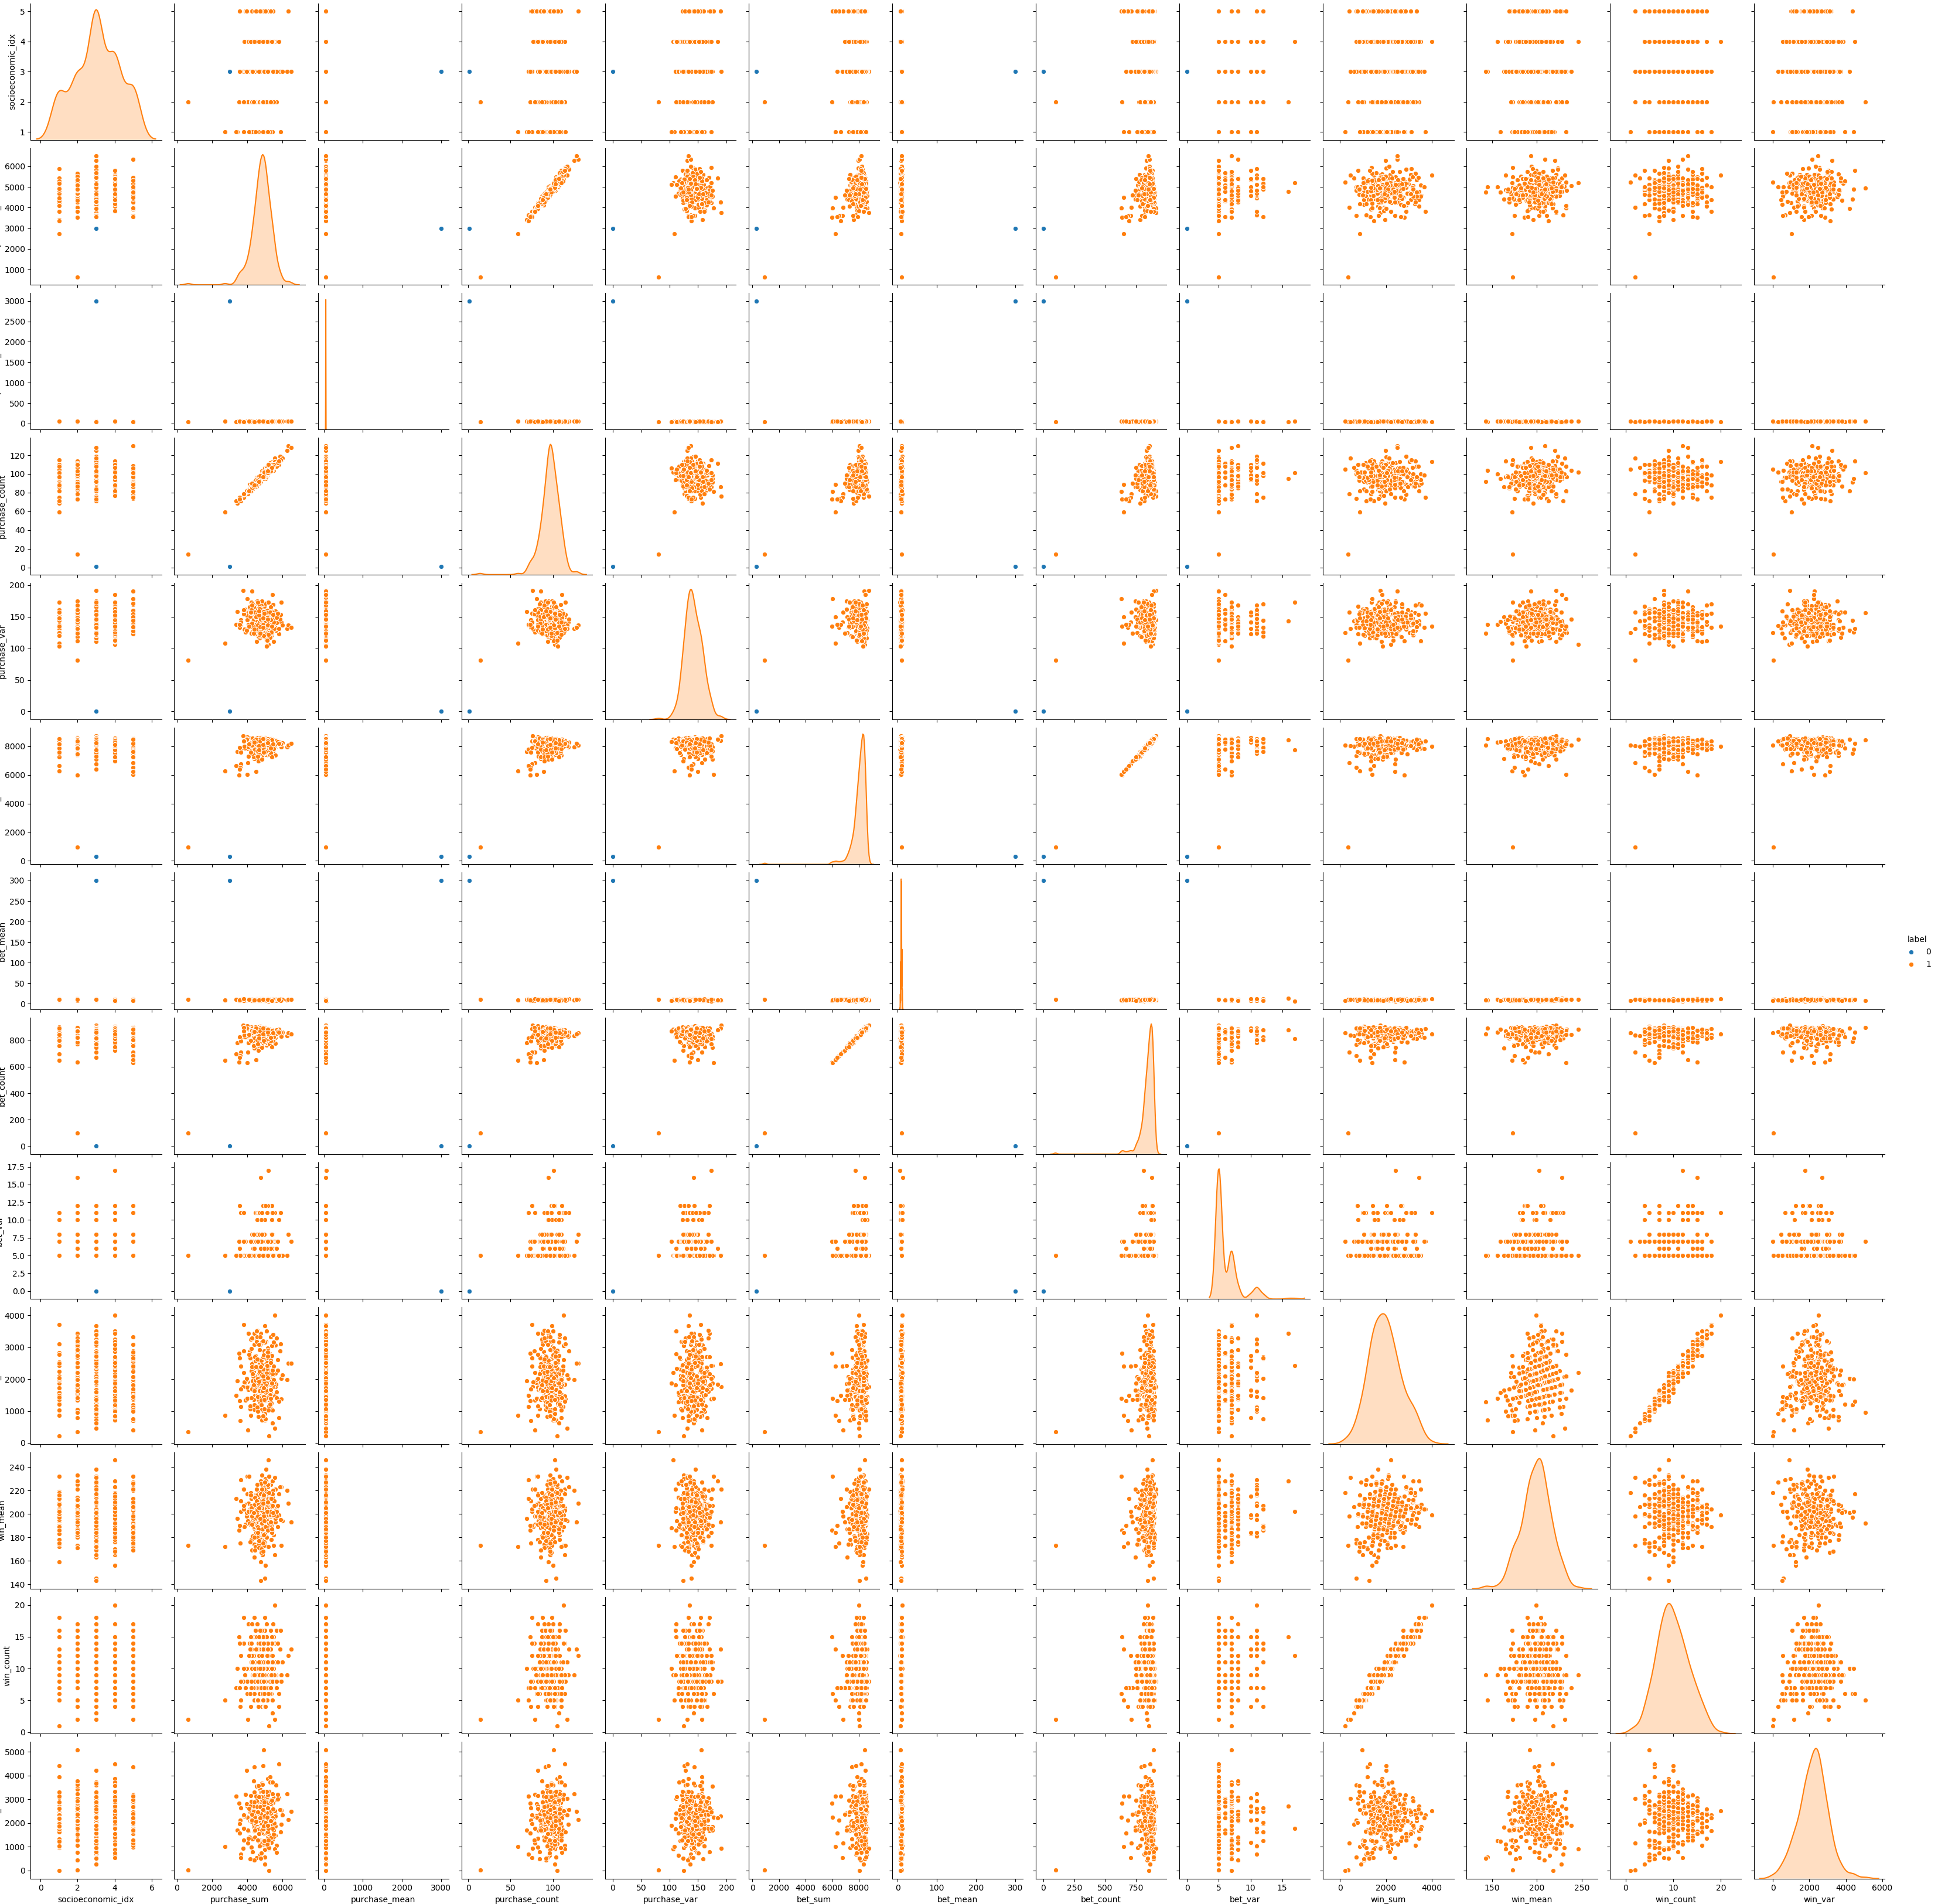

In [20]:
from IPython.display import display, HTML

# Display the `histograms` artifact
display(HTML('<h3>Histograms</h3>'), HTML(describe_run.outputs['histograms']))


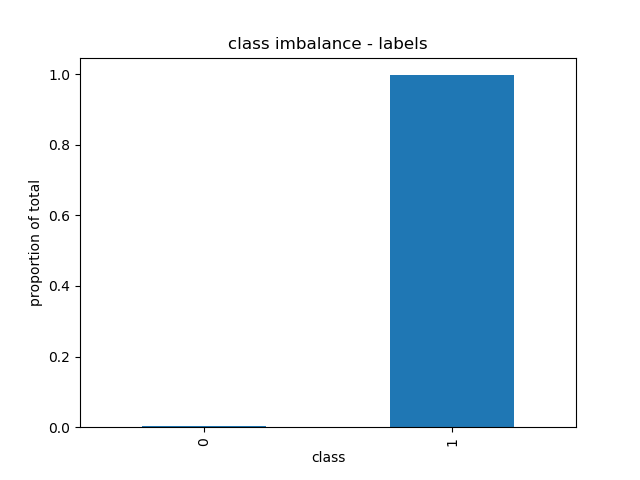

In [21]:
# Display the `imbalance` artifact
display(HTML('<h3>Imbalance<h3>'),
        HTML(filename=describe_run.outputs['imbalance']))


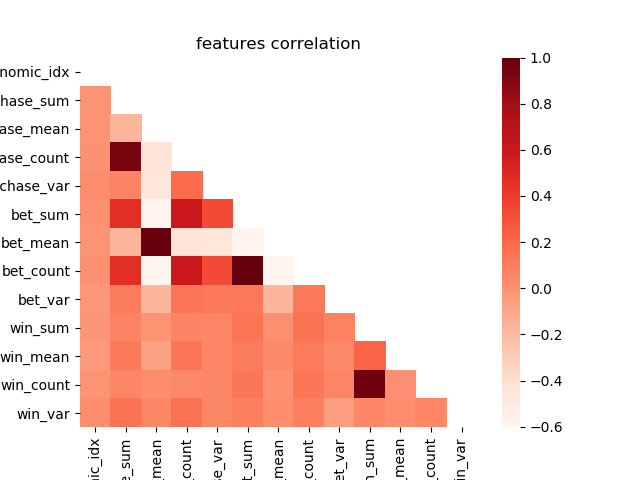

In [22]:
# Display the `correlation` artifact
display(HTML('<h3>Correlation Matrix<h3>'),
        HTML(filename=describe_run.outputs['correlation']))

## Step 4: Run Model Training at Scale <a id="gs-step-run-model-training"></a>


#### Add a Training Function <a id="gs-train-model-add-func"></a>


In [23]:
project.set_function('hub://sklearn_classifier', 'train')
train = project.func('train').apply(mount_v3io())

#### Run a Model-Training Task <a id="gs-train-model-run-task"></a>


In [24]:
# Configure the models to train
models = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

In [27]:
# Create a training task
train_task = NewTask(name="train",
                     params={"sample": -1,
                             "label_column": "label",
                             "test_size": 0.10},
                     inputs={"dataset": snapshot_data_run.outputs['snapshot_dataset']})

# Run the training task
train_run = train.run(train_task.with_hyper_params({'model_pkg_class': models},
                                                   selector='max.accuracy'),
                      artifact_path=artifact_path)

[mlrun] 2020-08-05 07:29:17,265 starting run train uid=b121247107f04932a5c4b1ef9ea4c871  -> http://mlrun-api:8080
[mlrun] 2020-08-05 07:29:17,415 Job is running in the background, pod: train-tfgtb
> --------------- Iteration: (1) ---------------
[mlrun] 2020-08-05 07:29:22,486 Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/mlrun/runtimes/local.py", line 194, in exec_from_params
    val = handler(*args_list)
  File "main.py", line 110, in train_model
    plots_artifact_path=plots_path)
  File "/opt/conda/lib/python3.7/site-packages/mlrun/mlutils/models.py", line 349, in eval_model_v2
    cmd = plot_calibration_curve(ytest, [yprob], pcurve_names)
  File "/opt/conda/lib/python3.7/site-packages/scikitplot/metrics.py", line 1018, in plot_calibration_curve
    probas = probas[:, 1]
IndexError: index 1 is out of bounds for axis 1 with size 1


[mlrun] 2020-08-05 07:29:22,521 exec error - index 1 is out of bounds for axis 1 with size 1
> --------------- Itera

2020-08-05 07:29:28,546 WARNING Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) after connection broken by 'ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))': /api/run/model-deployment-with-streaming-iguazio/b121247107f04932a5c4b1ef9ea4c871?iter=0


[mlrun] 2020-08-05 07:29:32,574 no returned result (job may still be in progress)


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
model-deployment-with-streaming-iguazio,...9ea4c871,0,,created,train,v3io_user=iguaziokind=jobowner=iguazio,dataset,sample=-1label_column=labeltest_size=0.1,,


to track results use .show() or .logs() or in CLI: 
!mlrun get run b121247107f04932a5c4b1ef9ea4c871 --project model-deployment-with-streaming-iguazio , !mlrun logs b121247107f04932a5c4b1ef9ea4c871 --project model-deployment-with-streaming-iguazio


### Review the Run Output <a id="gs-train-model-run-output-review"></a>


In [26]:
# Display the name of the selected model
display(HTML(f'<b>Best model:</b> '
             f'{models[train_run.outputs["best_iteration"]-1]}'))

# Display the accuracy for the optimal run iteration
display(HTML(f'<b>Accuracy:</b> {train_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML('<h3>Confusion Matrix:</h3>'),
        HTML(filename=train_run.outputs['confusion-matrix']))
display(HTML('<h3>ROC Curve:</h3>'), HTML(filename=train_run.outputs['roc-binary']))

AttributeError: 'NoneType' object has no attribute 'outputs'

## Step 5: Test Your Model <a id="gs-step-test-model"></a>


In [ ]:
project.set_function('hub://test_classifier', 'test')
test = project.func('test').apply(mount_v3io())

#### Run a Model-Testing Task <a id="gs-test-model-run-task"></a>


In [ ]:
test_task = NewTask(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']}
                    )
test_run = test.run(test_task,
                    artifact_path=artifact_path)

### Review the Run Output <a id="gs-test-model-run-output-review"></a>


In [ ]:
# Display the model accuracy
display(HTML(f'<b>Test Accuracy:</b> {test_run.outputs["accuracy"]}'))

# Display HTML output artifacts
display(HTML("<h3>Confusion matrix:</h3>"),
        HTML(filename=test_run.outputs['confusion-matrix']))
display(HTML("<h3>ROC Curve:</h3>"), HTML(filename=test_run.outputs['roc-binary']))

## Step 6: Save project<a id="gs-step-create-n-run-ml-pipeline"></a>


In [ ]:
project.save(path.join(project_path, 'project.yaml'))